In [103]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 
from src.load_data import load_data
from src.utils import load_ei_results, best_method, f_baseline
from eipy.metrics import scores
from matplotlib.patches import ConnectionStyle
from collections import defaultdict
plt.rcParams["font.family"] = ['Arial']
plt.rcParams['font.size'] = '8'
plt.rc('legend',fontsize=7)
plt.rc('legend',fontsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
palette = seaborn.color_palette("colorblind", desat=1).as_hex()
red_hex = "#D22B2B"
linewidth=1.5

# Visualisation of cross validation results

### Define results path:

In [51]:
dirname = os.path.dirname(os.path.dirname(os.getcwd())) 
results_path = os.path.join(dirname, "results/cross_validation")
save_path = os.path.join(dirname, "figures/cross_validation")

### Load EI results:

In [52]:
modality_dict = {
                 "ERK+Akt": "EI.ERK_Akt",
                 "ERK": "EI.ERK",
                 "Akt": "EI.Akt"
                }

results_dict = {
             "XGBoost": "xgboost",
             "No transformation": "traditional_ml",
             "DWT": "transformations/dwt",
             "tsfresh": "transformations/tsfresh",
             "MiniRocket": "transformations/minirocket",
             "Fourier": "transformations/fourier"
            }

meta_master = []
base_master = []

for transform_key, transform_path in results_dict.items():
    for modality_key, modality_path in modality_dict.items():
        path = os.path.join(results_path, transform_path, modality_path)
        base_df, meta_df = load_ei_results(path)
        base_df["Transformation"] = transform_key
        base_master.append(base_df)
        if meta_df is not None:
            meta_df["Modalities included"] = modality_key
            meta_df["Transformation"] = transform_key
            meta_master.append(meta_df)

base_master = pd.concat(base_master).reset_index(level=['modality', 'base predictor'])
meta_master = pd.concat(meta_master).reset_index().rename(columns={"index": "ensemble method"})

### Load deep learning results

In [53]:
modality_dict = {
                 "ERK+Akt": "ERK_Akt.csv",
                 "ERK": "ERK.csv",
                 "Akt": "Akt.csv"
                }

results_dict = {
             "LSTM": "dl/lstm",
             "CNN": "dl/cnn"
                }

dl_f = defaultdict(dict)
dl_auc = defaultdict(dict)

for method_key, method_path in results_dict.items():
    for modality_key, modality_path in modality_dict.items():
        path = os.path.join(results_path, method_path, modality_path)
        predictions_df = pd.read_csv(path)
        y_pred = predictions_df["predictions"].to_numpy()
        y_test = predictions_df["labels"].to_numpy()
        score_dict = scores(y_test, y_pred, metrics=None)
        dl_f[method_key][modality_key] = score_dict["fmax (minority)"]
        dl_auc[method_key][modality_key] = score_dict["auc"]

### Examine deep learning results:

In [54]:
print("Fmax/AUC scores for LSTM method:\n", 
      "ERK+Akt: ", dl_f["LSTM"]["ERK+Akt"][0], "/", dl_auc["LSTM"]["ERK+Akt"][0], "\n",
      "ERK: ", dl_f["LSTM"]["ERK"][0], "/", dl_auc["LSTM"]["ERK"][0], "\n",
      "Akt: ", dl_f["LSTM"]["Akt"][0], "/", dl_auc["LSTM"]["Akt"][0],
      )

print("Fmax/AUC scores for CNN method:\n", 
      "ERK+Akt: ", dl_f["CNN"]["ERK+Akt"][0], "/", dl_auc["CNN"]["ERK+Akt"][0], "\n",
      "ERK: ", dl_f["CNN"]["ERK"][0], "/", dl_auc["CNN"]["ERK"][0], "\n",
      "Akt: ", dl_f["CNN"]["Akt"][0], "/", dl_auc["CNN"]["Akt"][0],
      )

Fmax/AUC scores for LSTM method:
 ERK+Akt:  0.5214285714285715 / 0.7400578569277756 
 ERK:  0.5171898355754858 / 0.7264001806684733 
 Akt:  0.46994535519125685 / 0.6765980556630962
Fmax/AUC scores for CNN method:
 ERK+Akt:  0.46171693735498837 / 0.6603620897320086 
 ERK:  0.47861271676300576 / 0.6825558136533746 
 Akt:  0.4241733181299886 / 0.6130844840194434


### Extract XGBoost performance scores

In [55]:
xgboost_scores = base_master[base_master["Transformation"] == "XGBoost"].drop_duplicates()
xgboost_scores = xgboost_scores.replace({"concat": "ERK+Akt"})

xgboost_scores[xgboost_scores['modality']=='ERK+Akt']['fmax (minority)'].to_numpy()[0]

0.49472096530920057

### Best ERK base predictor:

In [56]:
best_method(base_master[base_master["modality"] == "ERK"].reset_index(drop=True))

modality                        ERK
base predictor     GradientBoosting
fmax (minority)            0.528771
auc                         0.73995
Transformation           MiniRocket
Name: 63, dtype: object

### Best Akt base predictor:

In [57]:
best_method(base_master[base_master["modality"] == "Akt"].reset_index(drop=True))

modality                         Akt
base predictor                   SVM
fmax (minority)             0.481633
auc                         0.679233
Transformation     No transformation
Name: 9, dtype: object

### Best ERK+Akt ensemble:

In [74]:
best_erk_akt = best_method(meta_master[meta_master["Modalities included"] == "ERK+Akt"].reset_index(drop=True))
best_erk_akt

ensemble method              LR
fmax (minority)        0.542373
auc                    0.757114
Modalities included     ERK+Akt
Transformation              DWT
Name: 18, dtype: object

### Best ERK ensemble:

In [75]:
best_erk = best_method(meta_master[meta_master["Modalities included"] == "ERK"].reset_index(drop=True))
best_erk

ensemble method              RF
fmax (minority)        0.528239
auc                    0.726551
Modalities included         ERK
Transformation              DWT
Name: 21, dtype: object

### Best Akt ensemble:

In [60]:
best_method(meta_master[meta_master["Modalities included"] == "Akt"].reset_index(drop=True))

ensemble method                       DT
fmax (minority)                  0.47619
auc                             0.643457
Modalities included                  Akt
Transformation         No transformation
Name: 3, dtype: object

### Best DWT Akt ensemble:

In [72]:
best_dwt_akt = best_method(meta_master[(meta_master["Modalities included"] == "Akt") & (meta_master["Transformation"] == "DWT")].reset_index(drop=True))
best_dwt_akt

ensemble method              NB
fmax (minority)        0.461538
auc                    0.660714
Modalities included         Akt
Transformation              DWT
Name: 7, dtype: object

### Median fmax for each transformation: ERK+Akt

In [64]:
print("Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations, respectively, ")
print(meta_master[(meta_master["Transformation"] == "DWT") 
            & (meta_master["Modalities included"] == "ERK+Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "MiniRocket") 
            & (meta_master["Modalities included"] == "ERK+Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "tsfresh") 
            & (meta_master["Modalities included"] == "ERK+Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "Fourier") 
            & (meta_master["Modalities included"] == "ERK+Akt")]["fmax (minority)"].median())

Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations, respectively, 
0.5181428137135121
0.5000233597175195
0.49683337191351595
0.4811408663240683


### Median fmax for each transformation: ERK

In [15]:
print("Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations, respectively, ")
print(meta_master[(meta_master["Transformation"] == "DWT") 
            & (meta_master["Modalities included"] == "ERK")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "MiniRocket") 
            & (meta_master["Modalities included"] == "ERK")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "tsfresh") 
            & (meta_master["Modalities included"] == "ERK")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "Fourier") 
            & (meta_master["Modalities included"] == "ERK")]["fmax (minority)"].median())

Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations are, respectively, 
0.5159777756367023
0.4977030352748154
0.5025523137332869
0.47794130423450504


### Median fmax for each transformation: Akt

In [66]:
print("Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations are, respectively, ")
print(meta_master[(meta_master["Transformation"] == "DWT") 
            & (meta_master["Modalities included"] == "Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "MiniRocket") 
            & (meta_master["Modalities included"] == "Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "tsfresh") 
            & (meta_master["Modalities included"] == "Akt")]["fmax (minority)"].median())
print(meta_master[(meta_master["Transformation"] == "Fourier") 
            & (meta_master["Modalities included"] == "Akt")]["fmax (minority)"].median())

Median fmax values for each DWT, minirocket, tsfresh and Fourier transformations are, respectively, 
0.45494568324757007
0.452265916457709
0.4524861364974132
0.43681640146021206


## Plot boxplot for each transformation

### Figure parameters:

In [67]:
kinase_label = "Modalities included"
f_label = r"F$_{\rm max}$ score (divided class)"
auc_label = r"AUC score"
boxplot_kwargs = dict(palette = [palette[0], palette[2], palette[3], palette[8], palette[4]],
                      fliersize = 1,
                      linewidth = linewidth
                      )
flier_props = dict(marker='o', markersize=1)

### Fmax of the divided (minority) class

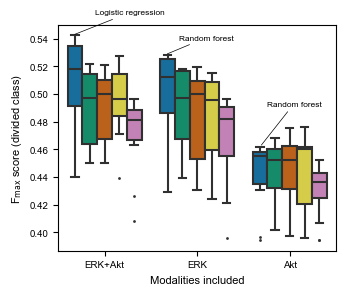

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

boxplots = seaborn.boxplot(ax=ax, data=meta_master, x="Modalities included", y="fmax (minority)", hue="Transformation",
                order=["ERK+Akt", "ERK", "Akt"],
                hue_order=["DWT", "tsfresh", "MiniRocket", "No transformation", "Fourier"],
                **boxplot_kwargs, flierprops=flier_props
                )

boxplots.annotate(f'Logistic regression', 
                xy=(-0.35, best_erk_akt['fmax (minority)']), 
                xytext=(-0.1, best_erk_akt['fmax (minority)'] + 0.015),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="black"))

boxplots.annotate(f'Random forest', 
                xy=(.65, best_erk['fmax (minority)']), 
                xytext=(.8, best_erk['fmax (minority)'] + 0.009),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="black"))

boxplots.annotate(f'Random forest', 
                xy=(1.675, best_dwt_akt['fmax (minority)']), 
                xytext=(1.75, best_dwt_akt['fmax (minority)'] + 0.03),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="black"))

ax.set_xlabel(kinase_label)
ax.set_ylabel(f_label)

handles, labels = ax.get_legend_handles_labels()
plt.legend([],[], frameon=False)

fig.tight_layout()

plt.savefig(os.path.join(save_path, "all_transforms/transformations_f.svg"), dpi=300)

### AUC score

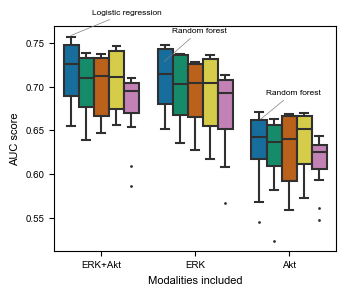

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

boxplots = seaborn.boxplot(ax=ax, data=meta_master, x="Modalities included", y="auc", hue="Transformation",
                order=["ERK+Akt", "ERK", "Akt"],
                hue_order=["DWT", "tsfresh", "MiniRocket", "No transformation", "Fourier"],
                **boxplot_kwargs, flierprops=flier_props
                )

boxplots.annotate(f'Logistic regression', 
                xy=(-0.35, best_erk_akt['auc']), 
                xytext=(-0.1, best_erk_akt['auc'] + 0.025),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="gray"))

boxplots.annotate(f'Random forest', 
                xy=(.65, best_erk['auc']), 
                xytext=(.75, best_erk['auc'] + 0.035),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="gray"))

boxplots.annotate(f'Random forest', 
                xy=(1.675, best_dwt_akt['auc']), 
                xytext=(1.75, best_dwt_akt['auc'] + 0.03),
                fontsize=6,
                arrowprops=dict(arrowstyle='-', 
                                hatch='x',
                                connectionstyle=ConnectionStyle("Arc3"),
                                linewidth=.5,
                                color="gray"))

ax.set_xlabel(kinase_label)
ax.set_ylabel(auc_label)

handles, labels = ax.get_legend_handles_labels()
plt.legend([],[], frameon=False)

fig.tight_layout()

plt.savefig(os.path.join(save_path, "all_transforms/transformations_auc.svg"), dpi=300)

In [80]:
fig = plt.figure(figsize=(7, 2))
fig.legend(handles=handles, labels=labels, ncol = len(ax.lines))
plt.savefig(os.path.join(save_path, "all_transforms/legend.svg"), dpi=300)

<Figure size 700x200 with 0 Axes>

### Plot transformations + EI vs LSTM vs XGBoost

### Figure parameters

In [81]:
x_label = "Modalities included"
f_label = r"F$_{\rm max}$ score (divided class)"
auc_label = r"AUC score"

### Create dataframe with best DWT+EI methods

In [93]:
best_ERK_Akt = pd.DataFrame(best_method(meta_master[(meta_master["Modalities included"] == "ERK+Akt") & (meta_master["Transformation"] == "DWT")].reset_index(drop=True))).T
best_ERK = pd.DataFrame(best_method(meta_master[(meta_master["Modalities included"] == "ERK") & (meta_master["Transformation"] == "DWT")].reset_index(drop=True))).T
best_Akt = pd.DataFrame(best_method(meta_master[(meta_master["Modalities included"] == "Akt") & (meta_master["Transformation"] == "DWT")].reset_index(drop=True))).T
best_df = pd.concat([best_ERK_Akt, best_ERK, best_Akt])
best_df = best_df.rename(columns={"ensemble method": "Method"})
best_df["hue_id"] = "EI"

#### Add LSTM benchmark

In [94]:
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["LSTM", dl_f["LSTM"]["ERK+Akt"][0], dl_auc["LSTM"]["ERK+Akt"][0], "ERK+Akt", "No transformation", "LSTM"])), index=[0])])
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["LSTM", dl_f["LSTM"]["ERK"][0], dl_auc["LSTM"]["ERK"][0], "ERK", "No transformation", "LSTM"])), index=[0])])
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["LSTM", dl_f["LSTM"]["Akt"][0], dl_auc["LSTM"]["Akt"][0], "Akt", "No transformation", "LSTM"])), index=[0])])

#### Add XGBoost benchmark

In [95]:
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["XGB", xgboost_scores[xgboost_scores['modality']=='ERK+Akt']['fmax (minority)'].to_numpy()[0], xgboost_scores[xgboost_scores['modality']=='ERK+Akt']['auc'].to_numpy()[0], "ERK+Akt", "No transformation", "XGBoost"])), index=[0])])
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["XGB", xgboost_scores[xgboost_scores['modality']=='ERK']['fmax (minority)'].to_numpy()[0], xgboost_scores[xgboost_scores['modality']=='ERK']['auc'].to_numpy()[0], "ERK", "No transformation", "XGBoost"])), index=[0])])
best_df = pd.concat([best_df, pd.DataFrame(dict(zip(best_df.columns, ["XGB", xgboost_scores[xgboost_scores['modality']=='Akt']['fmax (minority)'].to_numpy()[0], xgboost_scores[xgboost_scores['modality']=='Akt']['auc'].to_numpy()[0], "Akt", "No transformation", "XGBoost"])), index=[0])])

In [96]:
best_df = best_df.reset_index(drop=True)
best_df

,Method,fmax (minority),auc,Modalities included,Transformation,hue_id
0,LR,0.542373,0.757114,ERK+Akt,DWT,EI
1,RF,0.528239,0.726551,ERK,DWT,EI
2,NB,0.461538,0.660714,Akt,DWT,EI
3,LSTM,0.521429,0.740058,ERK+Akt,No transformation,LSTM
4,LSTM,0.51719,0.7264,ERK,No transformation,LSTM
5,LSTM,0.469945,0.676598,Akt,No transformation,LSTM
6,XGB,0.494721,0.712178,ERK+Akt,No transformation,XGBoost
7,XGB,0.486486,0.703903,ERK,No transformation,XGBoost
8,XGB,0.439752,0.626092,Akt,No transformation,XGBoost


#### Load random baseline performance for fmax

In [104]:
_, _, y, _ = load_data(os.path.join(dirname, "data/processed/mcf10a/high_dose/train"))
f_train_baseline = f_baseline(y)

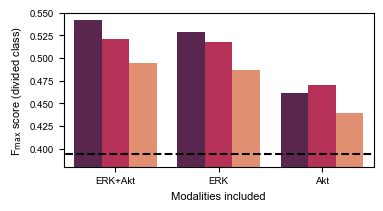

In [117]:
fig, ax = plt.subplots(1, 1,figsize=(4, 2))

plot1 = seaborn.barplot(ax=ax, data=best_df, x="Modalities included", y="fmax (minority)", hue="hue_id",
                # hue_order=modalityIDs, width=0.6, saturation=0.8,
                palette="rocket"
                ) 

ax.hlines(f_train_baseline, xmin=-2, xmax=3, color="black", linestyle="--", label="Random classifier")

ax.set_xlabel(x_label)
ax.set_ylabel(f_label)

handles, labels = ax.get_legend_handles_labels()

order = [1, 2, 3, 0]

handles = [handles[index] for index in order]
labels = [labels[index] for index in order]

ax.legend(handles[:], labels[:], title="")

plt.legend([],[], frameon=False)

ax.set_xlim(xmin=-0.5, xmax=2.5)
ax.set_ylim(ymin=0.38, ymax=0.55)

plt.savefig(os.path.join(save_path, "best_methods/f.svg"), dpi=300)

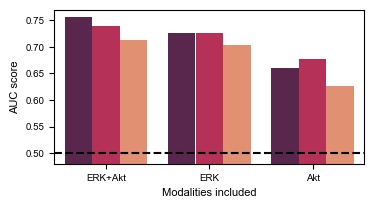

In [116]:
fig, ax = plt.subplots(1, 1,figsize=(4, 2))

plot1 = seaborn.barplot(ax=ax, data=best_df, x="Modalities included", y="auc", hue="hue_id",
                # hue_order=modalityIDs, width=0.6, saturation=0.8,
                palette="rocket"
                ) 

ax.hlines(0.5, xmin=-2, xmax=3, color="black", linestyle="--", label="Random classifier")

ax.set_xlabel(x_label)
ax.set_ylabel(auc_label)

handles, labels = ax.get_legend_handles_labels()

order = [1, 2, 3, 0]

handles = [handles[index] for index in order]
labels = [labels[index] for index in order]

ax.legend(handles[:], labels[:], title="")

plt.legend([],[], frameon=False)

ax.set_xlim(xmin=-0.5, xmax=2.5)
ax.set_ylim(ymin=0.48, ymax=0.77)

plt.savefig(os.path.join(save_path, "best_methods/auc.svg"), dpi=300)

In [119]:
fig = plt.figure(figsize=(7, 2))
fig.legend(handles=handles, labels=labels, ncol = len(ax.lines))
plt.savefig(os.path.join(save_path, "best_methods/legend.svg"), dpi=300)

<Figure size 700x200 with 0 Axes>